In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:
import re
import os, sys

# Read data

In [47]:
data = {x: pd.read_csv(os.path.join(x,'data.csv'), sep=',', keep_default_na=False) for x in os.listdir() if os.path.isdir(x)}
data.keys()

dict_keys(['EngNA-Rollins', 'Bernstein', 'Bates', 'England-Rollins', 'Gaeltacht', 'NewEngland'])

In [48]:
data['NewEngland'].head()

,utterance,spa_all,spa_1,spa_2,spa_2a,time_stamp,speaker,sentence,lemmas,pos,action,file_id,errors,child,age_months
0,0,$DHA:RP,DHA,RP,DIR,00:00:00,MOT,look at this .,look at this .,v prep pro_dem,,formatted/NewEngland/32/60.json,u49 u50 u182 u239 u300 u328 u369,sarah,30
1,1,$DJF:RT,DJF,RT,SPE,00:00:00,CHI,this .,this .,pro_dem,<bef> CHI spots boxes on table and moves towar...,formatted/NewEngland/32/60.json,u49 u50 u182 u239 u300 u328 u369,sarah,30
2,2,$DHA:RP,DHA,RP,DIR,00:00:00,CHI,it .,it .,pro_per,,formatted/NewEngland/32/60.json,u49 u50 u182 u239 u300 u328 u369,sarah,30
3,3,,,,,00:00:00,INV,oh yeah .,oh yeah .,co co,,formatted/NewEngland/32/60.json,u49 u50 u182 u239 u300 u328 u369,sarah,30
4,4,$NIA:RP,NIA,RP,DIR,00:00:00,MOT,one ?,one ?,det_num,,formatted/NewEngland/32/60.json,u49 u50 u182 u239 u300 u328 u369,sarah,30


In [49]:
for k,v in data.items():
    v['speaker'] = v.speaker.apply(lambda x: x if x == 'CHI' else 'MOT')

In [50]:
def get_transitions(data:pd.DataFrame, tag:str, 
                    origin:str = None, second:str = None, 
                    remove_empty:bool = False, normalize:str = 'true') -> pd.DataFrame:
    """Compute theoretic transition table between tags.
    Data must be filtered (age of interest, removal of empty values) before being passed as argument.

    Input:
    -------
    remove_empty: `bool`
        | whether to include unlabeled sentences as "break" between to labels (which could lead to unnaturally occuring links)
    
    normalize: `str`
        | one of true|remove_empty|false
        | if 'true': divide by number of rows
        | if 'remove_empty': only count non empty tags
        | if 'false': no normalization
        
    """
    dir_list = [None, 'CHI', 'MOT']
    if (origin not in dir_list) or (second not in dir_list):
        raise ValueError("Invalid argument; origin and second must be one of None|CHI|MOT")
    if normalize not in ['true', 'remove_empty', 'false']:
        raise ValueError("Invalid value for 'normalize': {normalize}; must be one of true|remove_empty|false")
    if remove_empty:
        df = data[data[tag] != '']
    else:
        df = data.copy(deep=True)
    # first: shift elements & remove 1rst line 
    df['prev_speaker'] = data.speaker.shift(1)
    df['prev_tag'] = data[tag].shift(1)
    df.dropna(subset=['prev_speaker', 'prev_tag'], inplace=True)
    # second: remove uninteresting rows
    if origin is not None:
        df = df[df['prev_speaker'] == origin]
    if second is not None:
        df = df[df['speaker'] == second]
    # remove empty line - post shift
    # df = df[df[tag] != '']
    # groupby & pivot 
    n = df.shape[0]
    res = df.groupby(by=['prev_tag', tag]).agg({'sentence':'count'}).reset_index().pivot_table(values='sentence', index='prev_tag', columns=tag).fillna(0)
    # Check matrix is square
    all_cols = set(list(res.columns)+list(res.T.columns))
    for col in list(all_cols - set(res.columns)):
        res[col] = 0
    res = res.T # pivot - simpler way of adding data
    res.sort_index(inplace=True) # order rows with new data
    for col in list(all_cols - set(res.columns)):
        res[col] = 0
    res = res.T
    res.sort_index(inplace=True) # order rows with new data
    # Normalize and return
    if normalize == 'true':
        return res/n
    elif normalize == 'remove_empty': # TODO
        return 
    else:
        return res



In [51]:
tmp = get_transitions(data['NewEngland'][data['NewEngland'].age_months == 14], 'spa_2', 'CHI', 'CHI')

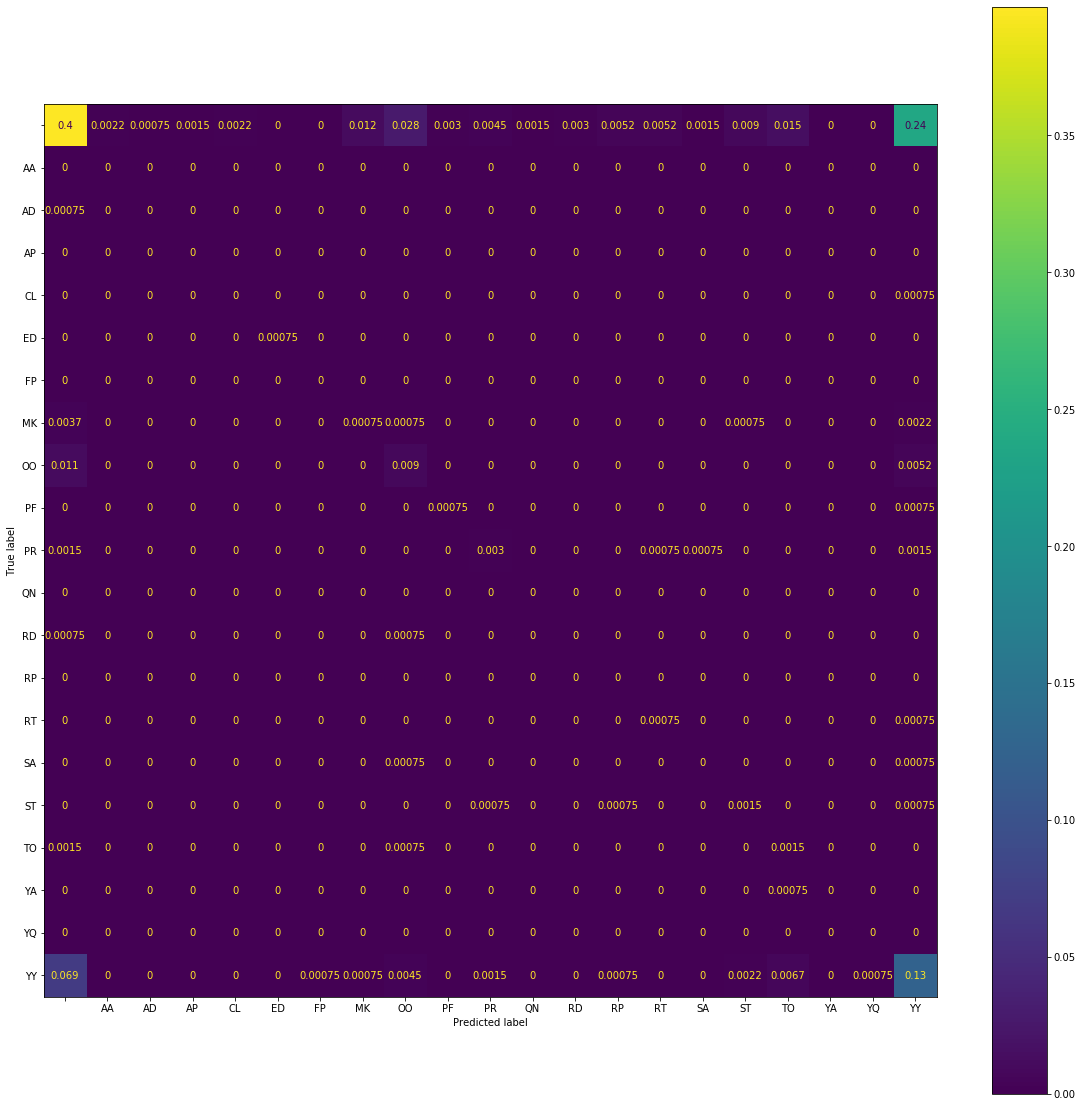

In [52]:
fig, ax = plt.subplots(figsize=(20,20))
disp = ConfusionMatrixDisplay(confusion_matrix=tmp.values, display_labels=tmp.columns)
disp.plot(cmap='viridis', ax=ax)

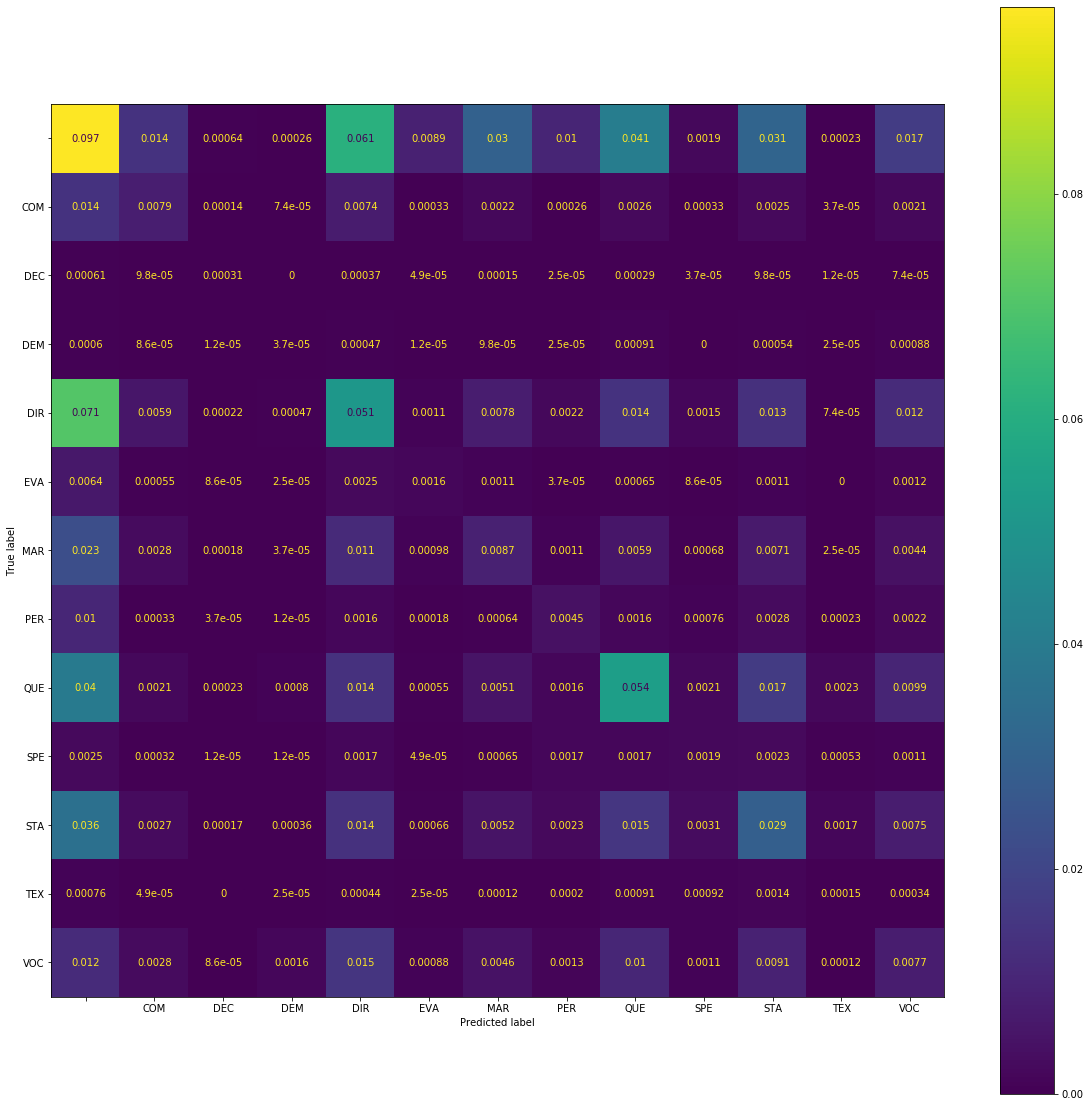

In [53]:
tmp = get_transitions(data['NewEngland'], 'spa_2a')
fig, ax = plt.subplots(figsize=(20,20))
disp = ConfusionMatrixDisplay(confusion_matrix=tmp.values, display_labels=tmp.columns)
disp.plot(cmap='viridis', ax=ax)

In [54]:
def plot_frequency(series_list: list, series_names: list, 
                    figsize:tuple = (12,5), 
                    log_scale:bool = False, remove_empty:bool = True,
                    as_percentage:bool = True ):
    if len(series_list) != len(series_names):
        raise ValueError("both lists must be of the same dimension.")

    fig, ax = plt.subplots(figsize=figsize)
    if log_scale:
        ax.set_yscale('log')
    # get counters
    freq = pd.concat([x.value_counts().rename(y) for x,y in zip(series_list, series_names)], axis=1)
    if remove_empty:
        freq.drop('', inplace=True)
    if as_percentage:
        freq = freq / freq.sum(axis=0)
    ymm = (1 if log_scale else 0, freq.max().max() + (20 if not as_percentage else 0.01))
    # xticks set manually - pandas bug
    freq.fillna(0).reset_index(drop=True).plot(ax = ax)
    ax.set_xticks(range(len(freq.index)))
    ax.set_xticklabels(freq.index, rotation=90)

    return freq.fillna(0)

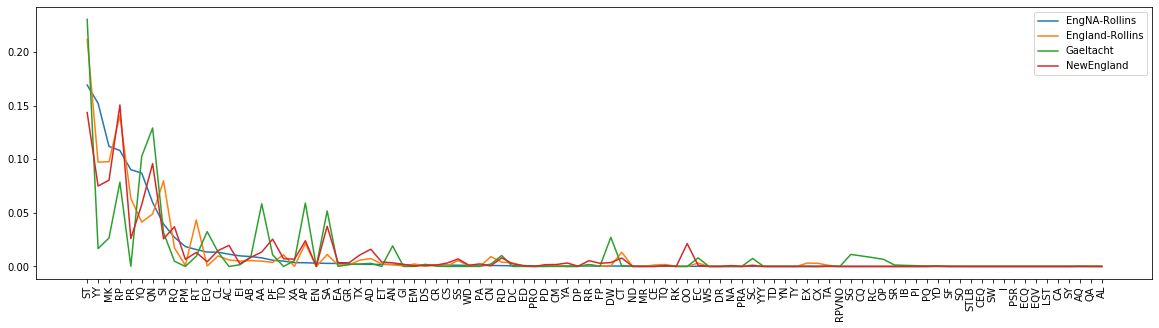

In [55]:
l = ['EngNA-Rollins', 'England-Rollins', 'Gaeltacht', 'NewEngland']
tag = 'spa_2'
counters_comp = plot_frequency([data[k][tag] for k in l], l, figsize=(20,5))

In [56]:
def color_cell(s):
    if s > 0:
        return 'background-color: blue'
    return ''

In [57]:
weird_labels = [x for x in counters_comp.index if len(x) != 2]
print(weird_labels)
counters_comp.loc[weird_labels,:].style.applymap(color_cell)

['PRO', 'PRA', 'YYY', 'RPVNO', 'STLB', 'CEQ', 'I', 'PSR', 'ECQ', 'EQV', 'LST']


,EngNA-Rollins,England-Rollins,Gaeltacht,NewEngland
PRO,0.000573,0.000000,0.000000,0.000000
PRA,0.000064,0.000000,0.000000,0.000000
YYY,0.000064,0.000000,0.000090,0.000000
RPVNO,0.000000,0.000121,0.000000,0.000000
STLB,0.000000,0.000000,0.000045,0.000000
CEQ,0.000000,0.000000,0.000045,0.000000
I,0.000000,0.000000,0.000045,0.000000
PSR,0.000000,0.000000,0.000045,0.000000
ECQ,0.000000,0.000000,0.000045,0.000000
EQV,0.000000,0.000000,0.000045,0.000000


In [58]:
data['Gaeltacht'][data['Gaeltacht']['spa_2'].isin(weird_labels)]

,utterance,spa_all,spa_1,spa_2,spa_2a,time_stamp,speaker,sentence,lemmas,pos,translation,action,file_id,errors,child,age_months
568,568,$DCC:CEQ,DCC,CEQ,,00:00:00,MOT,hhmm ?,,,hhmm ?,,formatted/Gaeltacht/data/010817.json,u102 u169 u942 u943 u1340 u1340 u1341,eoin,20
4854,643,$DCC:I:CQ,DCC,I,,00:00:00,MOT,tuaille nach ea ? ?,,,"towel , , isn't it ?",,formatted/Gaeltacht/data/011111.json,u81 u89 u498 u545,eoin,23
5632,1421,$DCC:PSR,DCC,PSR,,00:00:00,MOT,níl mé ag déanamh aon rása eile .,,,I'm not doing any other race .,,formatted/Gaeltacht/data/011111.json,u81 u89 u498 u545,eoin,23
6301,432,$DCC:EQV,DCC,EQV,,00:00:00,MOT,tá tú ag fáil leabhar .,,,you are getting a book .,,formatted/Gaeltacht/data/010901.json,u218 u219 u472 u544 u548 u549 u574 u602 u604 u...,eoin,21
8605,1152,$DCC:ECQ,DCC,ECQ,,00:00:00,MOT,hhmm ?,,,hhmm ?,,formatted/Gaeltacht/data/010914.json,u554 u634 u644 u714 u714 u714 u726 u1327 u1328,eoin,21
14266,358,$DJF:LST:LB,DJF,LST,,00:00:00,CHI,Daidí .,,,Daddy .,,formatted/Gaeltacht/data/010720.json,u13 u46 u92 u108 u343 u367 u393 u476 u501 u613...,eoin,19
25513,835,$YYY:YYY,YYY,YYY,,00:00:00,CHI,titithe titithe .,,,"fallen , fallen .",,formatted/Gaeltacht/data/010606.json,u23 u25 u30 u34 u37 u42 u53 u57 u63 u68 u70 u8...,eoin,18
25954,1276,$DJF:STLB:CQ,DJF,STLB,,00:00:00,MOT,sin é daidí nach ea ? ?,,,"that's daddy , , isn't it ?",,formatted/Gaeltacht/data/010606.json,u23 u25 u30 u34 u37 u42 u53 u57 u63 u68 u70 u8...,eoin,18
30058,549,$DJF:YYY,DJF,YYY,,00:00:00,CHI,caitín a déanamh .,,,makes cat .,,formatted/Gaeltacht/data/020107.json,u6 u38 u43 u67 u195 u240 u261 u674 u720 u762 u...,eoin,25


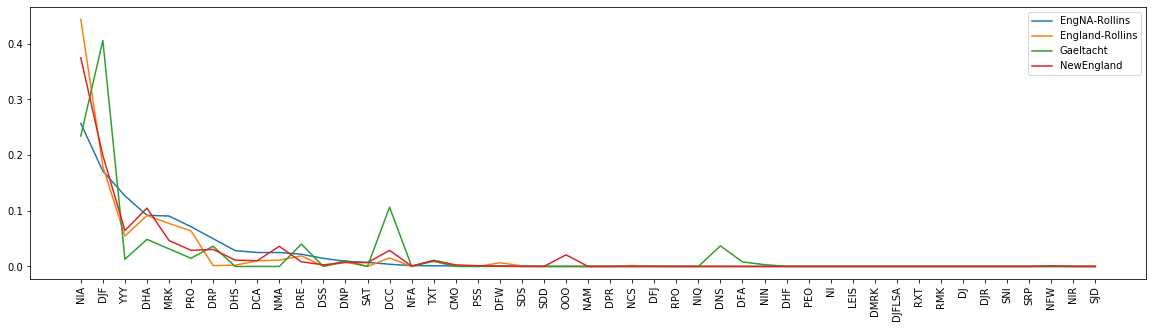

In [59]:
tag = 'spa_1'
counters_comp = plot_frequency([data[k][tag] for k in l], l, figsize=(20,5))

In [60]:
weird_labels = [x for x in counters_comp.index if len(x) != 3]
print(weird_labels)
counters_comp.loc[weird_labels,:].style.applymap(color_cell)

['NI', 'LEIS', 'DMRK', 'DJFLSA', 'DJ']


,EngNA-Rollins,England-Rollins,Gaeltacht,NewEngland
NI,0.000000,0.000000,0.000045,0.000000
LEIS,0.000000,0.000000,0.000045,0.000000
DMRK,0.000000,0.000000,0.000045,0.000000
DJFLSA,0.000000,0.000000,0.000045,0.000000
DJ,0.000000,0.000000,0.000045,0.000000


In [61]:
data['Gaeltacht'][data['Gaeltacht']['spa_1'].isin(weird_labels)]

,utterance,spa_all,spa_1,spa_2,spa_2a,time_stamp,speaker,sentence,lemmas,pos,translation,action,file_id,errors,child,age_months
9109,38,LEIS NA HAINMHITHE?,LEIS,,,00:00:00,MOT,an bhfuil tú ag iarraidh a dhul isteach i seom...,,,do you want to go into Labhaoise's room and pl...,,formatted/Gaeltacht/data/010928.json,u95 u1578 u1646 u1647 u1648 u1650 u1651,eoin,21
13909,1,$DJFLSA,DJFLSA,,,00:00:00,CHI,Teachín isteach .,,,Housey inside .,,formatted/Gaeltacht/data/010720.json,u13 u46 u92 u108 u343 u367 u393 u476 u501 u613...,eoin,19
22566,408,$DMRK:MK,DMRK,MK,MAR,00:00:00,CHI,anois .,,,now .,,formatted/Gaeltacht/data/011018.json,u105 u106 u465 u466 u479 u480 u812 u813 u994,eoin,22
24019,838,$NI:RP,NI,,,00:00:00,CHI,déan é .,,,do it .,,formatted/Gaeltacht/data/011025.json,u49 u97 u98 u148 u269 u539 u610 u687 u860,eoin,22
25081,403,$DJ:DW,DJ,,,00:00:00,MOT,níl sé dána céard é fhéin ? ?,,,"he isn't bold , what is it ?",,formatted/Gaeltacht/data/010606.json,u23 u25 u30 u34 u37 u42 u53 u57 u63 u68 u70 u8...,eoin,18
